<a href="https://colab.research.google.com/github/joyejun/-Weather-prediction-using-LSTM/blob/main/LSTM%EC%9C%BC%EB%A1%9C_%EB%82%A0%EC%94%A8_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_Data = pd.read_csv('DailyDelhiClimateTrain.csv')
test_Data = pd.read_csv('DailyDelhiClimateTest.csv')

In [ ]:
train_Data.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
train_Temp = train_Data['meantemp']
print(train_Temp.head())

0    10.000000
1     7.400000
2     7.166667
3     8.666667
4     6.000000
Name: meantemp, dtype: float64


In [ ]:
idx_Label =[]
valid_Month =[1,4,7,10]

for i in range(len(train_Temp)):
  date = train_Data['date'][i]
  year, month, day = date.split('-')
  if int(month) in valid_Month :
    if day == '01':
      idx_Label.append(date)
    else :
      idx_Label.append('')
  else :
    idx_Label.append('')

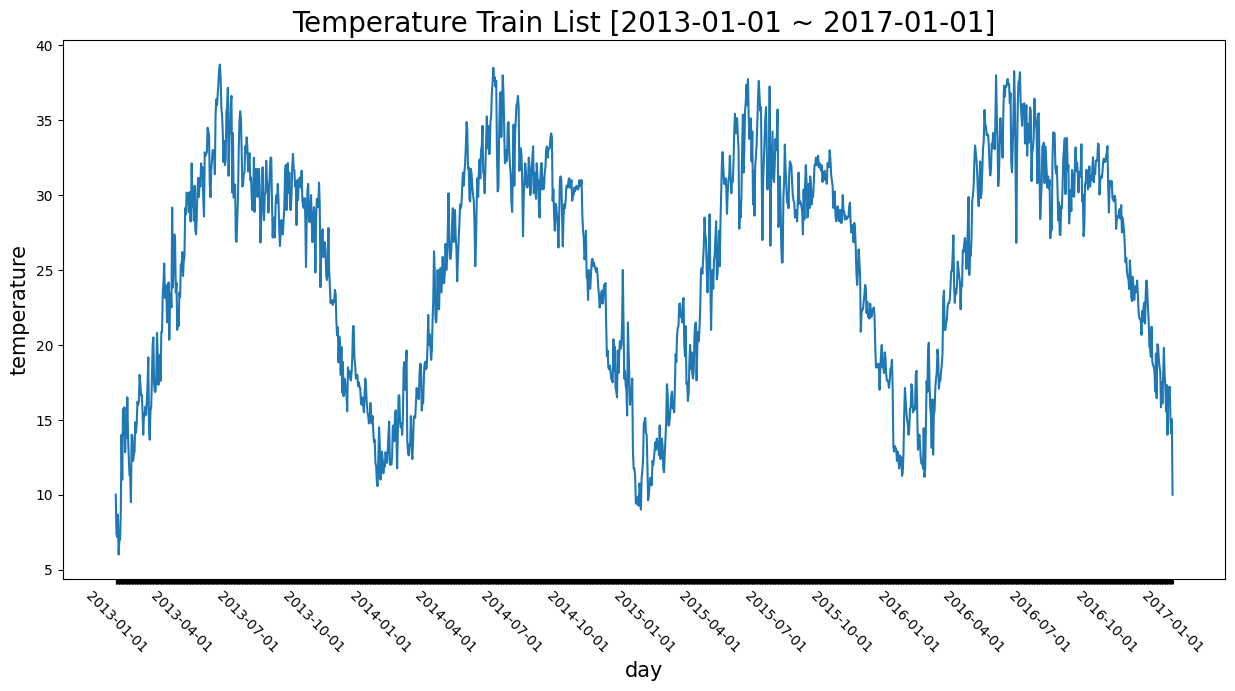

In [ ]:
plt.figure(figsize=(15,7))

plt.title('Temperature Train List [2013-01-01 ~ 2017-01-01]', fontsize=20)
plt.xlabel('day', fontsize=15)
plt.ylabel('temperature', fontsize=15)
idx_List = list(range(len(train_Temp)))

plt.plot(idx_List, train_Temp)

plt.xticks(idx_List, labels = idx_Label, rotation = -45)

plt.show()

In [ ]:
test_Temp = test_Data['meantemp']


In [ ]:
for i in range(len(test_Temp)):
  date = test_Data['date'][i]
  year, month, day = date.split('-')
  if day == '01' :
    idx_Label.append(date)
  else :
    idx_Label.append('')

ValueError: The number of FixedLocator locations (114), usually from a call to set_ticks, does not match the number of labels (1576).

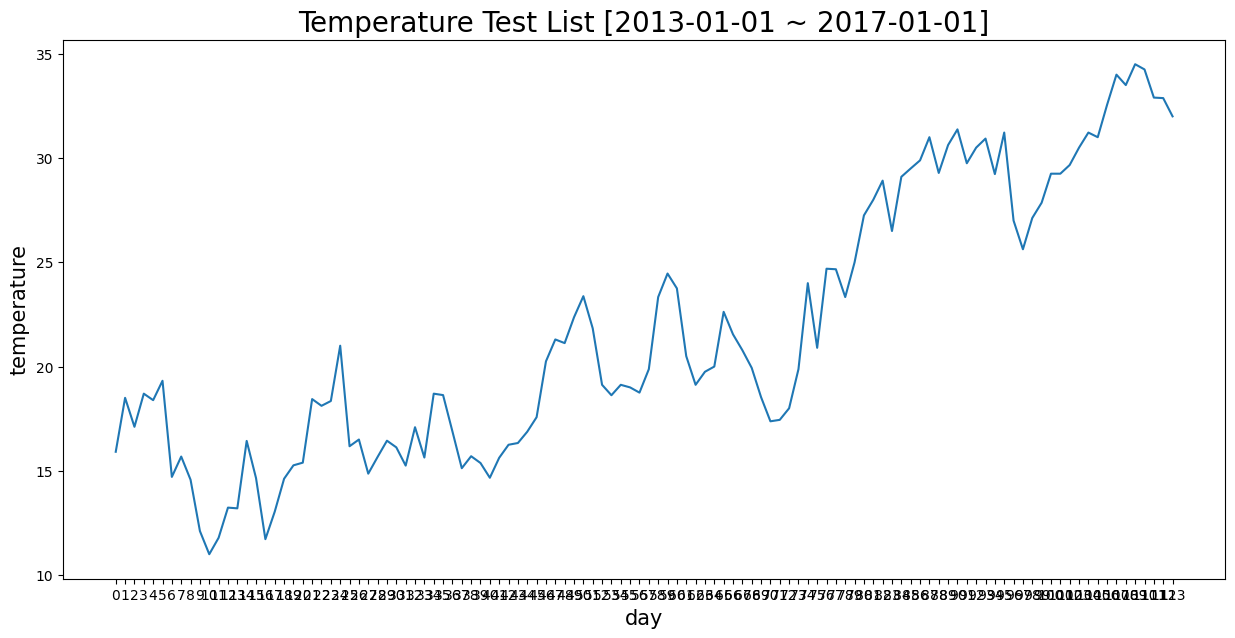

In [ ]:
plt.figure(figsize=(15,7))

plt.title('Temperature Test List [2013-01-01 ~ 2017-01-01]', fontsize=20)
plt.xlabel('day', fontsize=15)
plt.ylabel('temperature', fontsize=15)

idx_List = list(range(len(test_Temp)))

plt.plot(idx_List, test_Temp)

plt.xticks(idx_List, labels = idx_Label, fontsize = 12)

plt.show();

---
데이터 분석을 마치고  Time Series Forecasting 을 위한 데이터 전처리
---

In [ ]:
train_Temp = list(train_Temp)
temp_Data = { 0: train_Temp}

In [ ]:
temp_Data = pd.DataFrame(temp_Data)

In [ ]:
temp_Data.head()

,0
0,10.000000
1,7.400000
2,7.166667
3,8.666667
4,6.000000


meantemp 에 대한 석성만을 다루기 떄문에 이를 pd DataFrame으로 type변경

여기서 각 속성을 1칸식 아래로 이동하면서 옆에 이어붙인다.



In [ ]:
def makeSeriesData(df,n_in = 6):
  for i in range(1,n_in+1):
    df[i] = df[i-1].shift(1)
  return df



In [ ]:
temp_Data = makeSeriesData(temp_Data, 6)

In [ ]:
temp_Data.head()

,0,1,2,3,4,5,6
0,10.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,7.400000,10.000000,NaN,NaN,NaN,NaN,NaN
2,7.166667,7.400000,10.000000,NaN,NaN,NaN,NaN
3,8.666667,7.166667,7.400000,10.0,NaN,NaN,NaN
4,6.000000,8.666667,7.166667,7.4,10.0,NaN,NaN


#nan 모두 삭제

In [ ]:
temp_Data = temp_Data.dropna()
temp_Data = temp_Data.reset_index(drop= True)

In [ ]:
temp_Data.head()

,0,1,2,3,4,5,6
0,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000,10.000000
1,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000
2,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667
3,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667
4,15.714286,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000


# meantemp 속성에 대해서 Time series Forecasting을 위한 데이터 전처리를 마침

이제 Column 0~ Column 5까지의 수치를 가지고 Column 6의 수치를 예측할 것

-> 즉 앞선 6일의 meantemp 기록을 통해서 다음날의 meanTemp를 예측하는 것

In [ ]:
print('Data lenght : %d' %len(temp_Data))
length = 6

Data lenght : 1456


In [ ]:
temp_Data = np.array(temp_Data)

In [ ]:
X_train , Y_train = temp_Data[:,:-1],temp_Data[:,-1]

In [ ]:
print(X_train.shape)
print(Y_train.shape)

(1456, 6)
(1456,)


---
이제 위 데이터를 기반으로 LSTM 을 이용해 Deep Learning Model 제작

In [ ]:
from keras.layers import Embedding, Dense, LSTM, Dropout,Flatten, TimeDistributed,Conv1D, MaxPooling1D
from keras.models import Model
from keras import Input
from keras.models import Sequential

In [ ]:
model = Sequential()

model.add(LSTM(256, kernel_initializer='he_normal',
               activation='relu', input_shape=(length, 1)))

model.add(Dense(64,kernel_initializer='he_normal',activation='relu'))

model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.fit(X_train, Y_train, epochs = 150, batch_size = 32, verbose = 0)

In [ ]:
print(model.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 842,117 (3.21 MB)

 Trainable params: 280,705 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 561,412 (2.14 MB)

None


#훈련 평가

-훈령한 것을 토대로 날씨를 예측하고 평가해보기

In [ ]:
def model_predict(model, history, input_Length):
    # 리스트를 NumPy 배열로 변환 후 reshape
    X_input = np.array(history[-input_Length:]).reshape(1, input_Length, 1)
    Y_hat = model.predict(X_input)
    return Y_hat[0]

In [ ]:

test_Predict = model_predict(model, train_Temp, 6)

print('Prediction Temperature (2017-01-01): %.2f' % test_Predict)
print('Actual Temperature (2017-01-01): %.2f' % test_Temp[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Prediction Temperature (2017-01-01): 11.65
Actual Temperature (2017-01-01): 15.91


<ipython-input-84-3b4ebbbe76be>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Prediction Temperature (2017-01-01): %.2f' % test_Predict)


In [ ]:
def rmse(outputs, labels):
  return np.sqrt(((outputs -labels)**2).mean())

In [ ]:
def walk_forward_validation(model,train_Data, test_Data, input_Length):


  predict_List = []
  history = train_Data.copy()

  for i in range(len(test_Data)) :
    Y_hat  = model_predict(model, history, input_Length)

    predict_List.append(Y_hat)
    history.append(test_Data[i])
    predict_Array = np.array(predict_List)
    error = rmse(predict_Array, test_Data)

  return error , predict_List

In [ ]:
erroe, predictions = walk_forward_validation(model, list(train_Temp),list(test_Temp),6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

---
먼저 훈련데이터에서 맨 마지막 6개를 사용하여 예측을 시작함
예측값과 실제값 데이터를 통해 오차를 측정
그리고 test data를 훈련 데이터에 이어 붙인다.
---
이어 붙인 훈련 데이터에서 다시 맨 마지막 6개를 사용해 예측을 한다.
그리고 실제값과 비교해서 오차를 계산한다.

이와 같은 과정을 test data의 갯수 만큼 반복하고 오차를 계산



---
그래프로 시각화
---

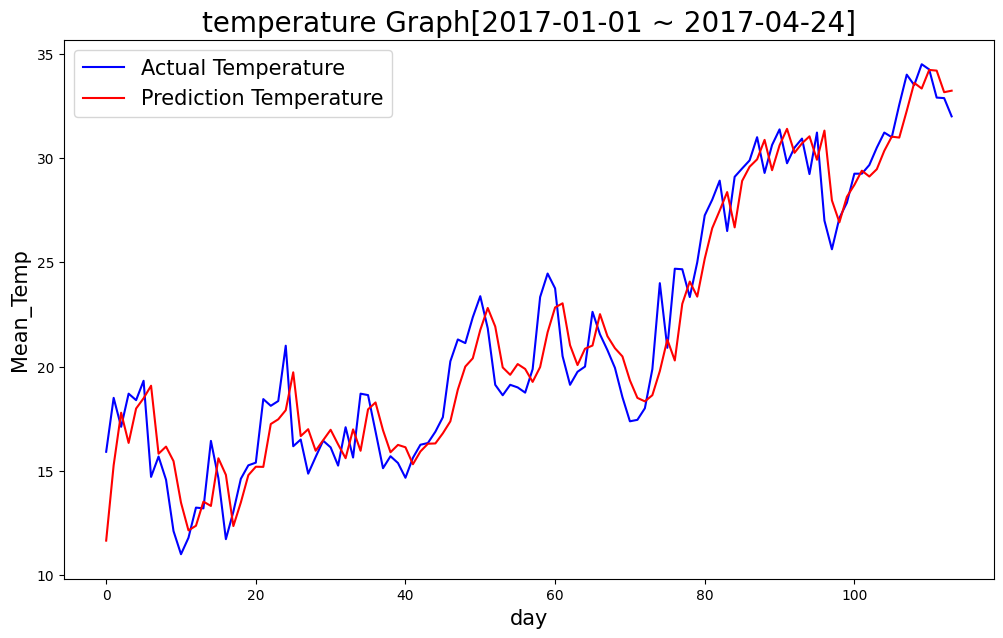

In [ ]:
plt.figure(figsize=(12,7))

plt.title('temperature Graph[2017-01-01 ~ 2017-04-24]',fontsize=20)

plt.xlabel('day', fontsize=15)
plt.ylabel('Mean_Temp', fontsize=15)

idx_List = list(range(len(test_Temp)))

plt.plot(idx_List, test_Temp, 'b',label ='Actual Temperature')
plt.plot(idx_List, predictions, 'r', label = 'Prediction Temperature')

plt.legend(loc ='best', fontsize = 15)